In [1]:
import sys
sys.path.append('/home/albert/github/tensorflow/src/')
import evaluation
import data
sys.path.append('/home/albert/github/tensorflow/')
import densenet
import dense

Using TensorFlow backend.


In [2]:
from keras.models import Model
from keras.losses import hinge
from keras.optimizers import Adam
from keras.layers import Dense, Activation
from keras.callbacks import History
from scipy import misc

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train_dict, train_files = data.get_data('train')
test_dict, test_files = data.get_data('test')

In [4]:
print len(train_dict.keys())
print len(test_dict.keys())

751
752


### Train CamNet

In [8]:
file_root = 'densenet_triplet_cam_neck_r6_all'

In [6]:
evaluation.plot_rank(file_root)

IOError: [Errno 2] No such file or directory: '/home/albert/github/tensorflow/models/densenet_triplet_cam_neck_r3_all/densenet_triplet_cam_neck_r3_all_score.npz'

In [9]:
file_name = file_root + '_' + str(4000)
json_file = '/home/albert/github/tensorflow/models/%s/%s.json' % (file_root, file_root)
weights_file = '/home/albert/github/tensorflow/models/%s/%s.npy' % (file_root, file_name)

input_shape = (256,128)
model = dense.DenseNetImageNet121(input_shape=(input_shape[0],input_shape[1],3), weights=None, cam_placement=[0,1,2,3])
model.set_weights(np.load(weights_file))

# model = evaluation.load_model(json_file, weights_file)

32 16
16 8
16 8
16 8


In [10]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_im (InputLayer)            (None, 256, 128, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 128, 64, 64)   9408        input_im[0][0]                   
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 128, 64, 64)   256         conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 128, 64, 64)   0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [11]:
pred = Dense(750, activation='softmax', name='pred')(model.layers[-5].output)

In [12]:
cam_model = Model(inputs=model.input, outputs=pred)
for layer in cam_model.layers[:-1]:
    layer.trainable = False
    
cam_model.compile(loss=hinge,
                  optimizer=Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1.0e-6), 
                  metrics=['acc'])

In [13]:
cam_model.layers[-2].trainable

False

In [14]:
def output_batch_generator(files_dict, files_arr, overlay, batch_size=50, preprocess=True, shape=(256,128)):
    while True:
        im_batch = []
        labels = []
        
        im_choice = np.random.choice(range(len(files_arr)), batch_size, replace=False)
        for i in im_choice:
            im_batch.append(data.imread_scale(files_arr[i][0], shape, preprocess).tolist())
            one_hot_label = np.zeros((750))
            one_hot_label[files_dict.keys().index(files_arr[i][1])] = 1
            labels.append(one_hot_label.tolist())
        
        if overlay:
            yield {'input_im' : np.array(im_batch), 'input_cam' : np.ones((batch_size, 128, 64))}, np.array(labels, dtype=np.int64)
        else:
            yield np.array(im_batch, dtype=np.float32), np.array(labels, dtype=np.int64)

In [15]:
steps_per_epoch = 100
epochs = 20

history = History()

cam_model.fit_generator(output_batch_generator(test_dict, test_files, True, preprocess=True), 
                     steps_per_epoch=steps_per_epoch,
                     epochs=epochs,
                     callbacks=[history])

Epoch 1/20
100/100 [==============================] - 162s - loss: 1.3826 - acc: 0.0110   
Epoch 2/20
100/100 [==============================] - 161s - loss: 1.3826 - acc: 0.0232   
Epoch 3/20
100/100 [==============================] - 161s - loss: 1.3826 - acc: 0.0386   
Epoch 4/20
100/100 [==============================] - 161s - loss: 1.3826 - acc: 0.0432   
Epoch 5/20
100/100 [==============================] - 161s - loss: 1.3826 - acc: 0.0476   
Epoch 6/20
100/100 [==============================] - 161s - loss: 1.3826 - acc: 0.0518   
Epoch 7/20
100/100 [==============================] - 161s - loss: 1.3825 - acc: 0.0586   
Epoch 8/20
100/100 [==============================] - 161s - loss: 1.3826 - acc: 0.0558   
Epoch 9/20
100/100 [==============================] - 161s - loss: 1.3825 - acc: 0.0672   
Epoch 10/20
100/100 [==============================] - 161s - loss: 1.3825 - acc: 0.0740   
Epoch 11/20
100/100 [==============================] - 161s - loss: 1.3825 - acc: 0.0666 

In [16]:
model_json = cam_model.to_json()
with open("/home/albert/github/tensorflow/models/%s_test.json" % file_root, "w") as json_file:
    json_file.write(model_json)

In [17]:
np.save("/home/albert/github/tensorflow/models/%s_test.npy" % file_root, cam_model.get_weights())

### Generate CAM from Weights

In [5]:
def get_cam(model, im):
    cam = cv2.resize(255 * im, (8,16)).astype(np.uint8)

    im_proc = densenet.preprocess_input(im.copy())
    
    overlay = False
    for layer in model.layers:
        if layer.name == 'input_cam':
            overlay = True
    
    shape = (256,128)
    if overlay:
        input_dict = {'input_im' : im_proc.reshape(1,shape[0],shape[1],3), 'input_cam' : np.ones((1,128,64))}
    else:
        input_dict = {'input_im' : im_proc.reshape(1,shape[0],shape[1],3)}
    pred = np.squeeze(model.predict(input_dict))
    
    pred_weights = model.layers[-1].get_weights()[0][..., pred.argmax()]
    pred_weights_tile = np.tile(pred_weights, [16,8,1])
    
    heatmap_model = Model(inputs=model.input, outputs=model.layers[-3].output)
    heatmap_model.compile(loss=hinge, optimizer=Adam(lr=0.002)) 
    
    pred_heatmap = heatmap_model.predict(input_dict)
    
    cam_sum = np.sum(np.multiply(np.squeeze(pred_heatmap), pred_weights_tile), axis=2)
    cam_sum = (cam_sum - cam_sum.min()) * 255.0 / (cam_sum - cam_sum.min()).max()
    
    return cam_sum

In [6]:
json_file_all = '/home/albert/github/tensorflow/pre/pre2/models/densenet_hinge_test.json'
weights_file_all = '/home/albert/github/tensorflow/pre/pre2/models/densenet_hinge_test_1000.npy'
cam_model_all = evaluation.load_model(json_file_all, weights_file_all)

cam_model_neck = evaluation.load_model(json_file_all, 
                                       '/home/albert/github/tensorflow/pre/pre2/models/densenet_triplet_cam_neck_r6_all_test.npy')
# input_shape = (256,128)
# model = dense.DenseNetImageNet121(input_shape=(input_shape[0],input_shape[1],3), weights=None, cam_placement=[3])
# model.set_weights(np.load('/home/albert/github/tensorflow/models/densenet_triplet_hinge_neck_aws_test.npy'))

preprocess False
keypoints ['Neck']


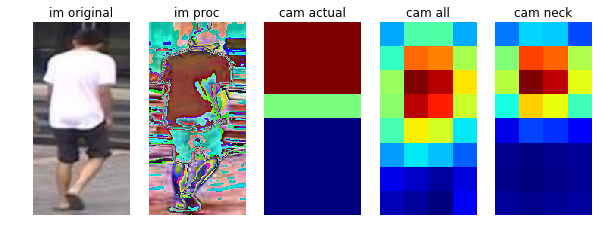

preprocess False
keypoints ['Neck']


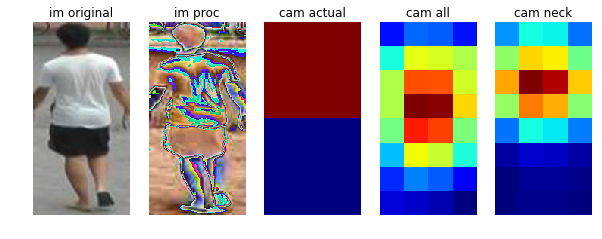

preprocess False
keypoints ['Neck']


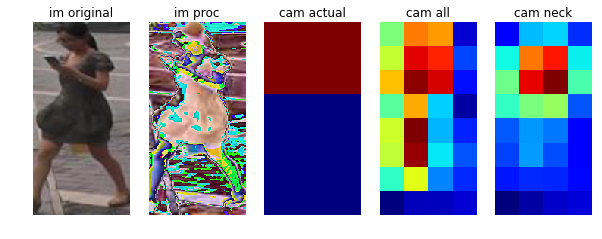

preprocess False
keypoints ['Neck']


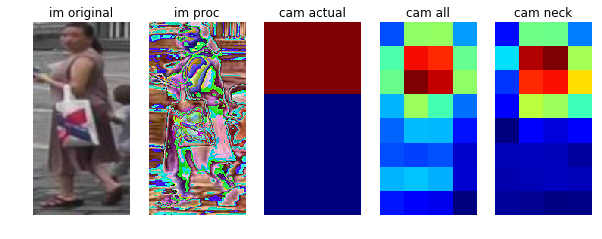

preprocess False
keypoints ['Neck']


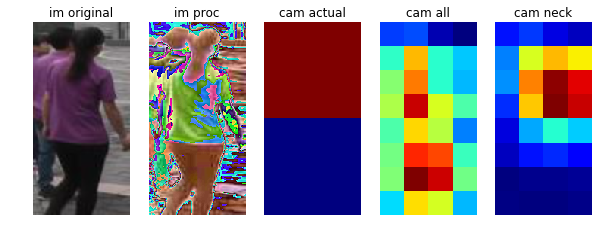

preprocess False
keypoints ['Neck']


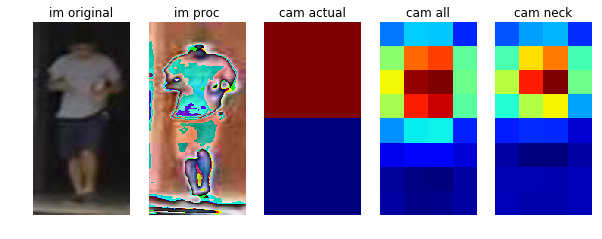

preprocess False
keypoints ['Neck']


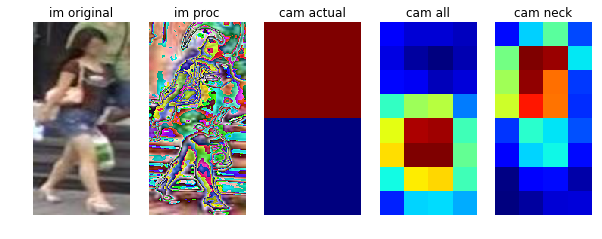

preprocess False
keypoints ['Neck']


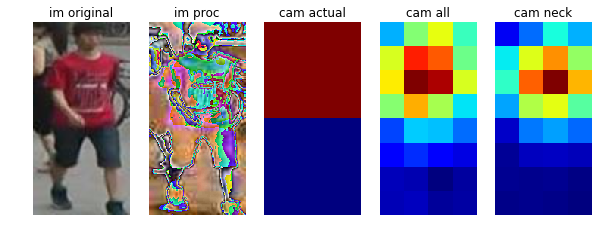

preprocess False
keypoints ['Neck']


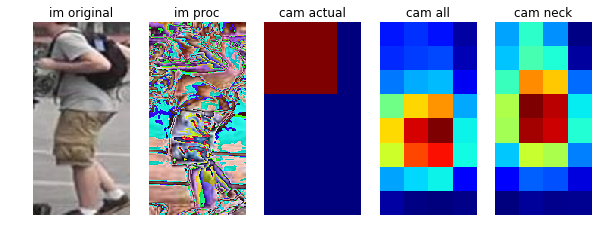

preprocess False
keypoints ['Neck']


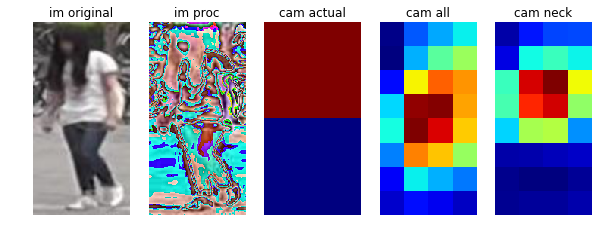

In [7]:
for i in range(10):
    batch = data.output_batch_generator(test_dict, P=1, K=1, preprocess=False,
                                        shape=(256,128), keypoints=['Neck'], r=0.5).next()
    im = batch[0]['input_im'][0]
    im_proc = densenet.preprocess_input(im.copy())

    cam_sum_all = get_cam(cam_model_all, im)
    cam_sum_neck = get_cam(cam_model_neck, im)

    plt.figure(figsize=(10,4))
    plt.subplot(151)
    plt.imshow(im.astype(np.uint8))
    plt.axis('off')
    plt.title('im original')

    plt.subplot(152)
    plt.imshow(im_proc)
    plt.axis('off')
    plt.title('im proc')

    plt.subplot(153)
    plt.imshow(cv2.resize(255 * batch[0]['input_cam'][0], (4,8)).astype(np.uint8), cmap=plt.cm.jet)
    plt.axis('off')
    plt.title('cam actual')

    plt.subplot(154)
    plt.imshow(cam_sum_all, cmap=plt.cm.jet)
    plt.axis('off')
    plt.title('cam all')

    plt.subplot(155)
    plt.imshow(cam_sum_neck, cmap=plt.cm.jet)
    plt.axis('off')
    plt.title('cam neck')

    plt.show()